<a href="https://colab.research.google.com/github/Sivasurya-J/Sivasurya-J/blob/main/NLP_FakeNewsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing - CT3 Project

## Fake news identification- Total marks (30)

### About the data set 

A full  dataset with the following attributes:


####  data:
**id:**  unique id for a news article<br>
**title:** the title of a news article <br> 
**author:**  author of the news article<br>
**text:** the text of the article; could be incomplete<br>


**label** - (Output variable) a label that marks the article as potentially unreliable <br>
1: unreliable <br>
0: reliable


Note: Remove the unneccssary data like description

# Table of Content

1. Data Preprocessing - **2 Marks**
2. Feature extraction - **3 Marks**
3. Design a LSTM Model - **5 Marks**
4. Test the Model - own data - **3 Marks**
5. Build the following models <br>
   Design Bideirectional LSTM - **5 Marks**<br>
   Design RNN (2 Layers) - **5 Marks**
6. Compare the Results of all above models - **2 Marks**
7. Intrepret your solution based on the results - **5 Marks**


<a id="logreg"> </a>
## 1. Data Pre-Processing

**Import the required libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import tensorflow as tf
import keras
from keras.layers import *
from keras.models import *

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

#### Load the csv file

In [3]:
train = pd.read_csv("/content/drive/My Drive/train.csv")
# test = pd.read_csv("test.csv/test.csv")

# print(train.shape, test.shape)
print(train.shape)
train.head(5)

(20800, 5)


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Prepare the data </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [4]:
train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [5]:
train[train['author'].isna() & train['text'].isna()].count()

id        39
title     39
author     0
text       0
label     39
dtype: int64

In [6]:
nan_idx = train[(train['author'].isna()) & (train['text'].isna())].index
train.drop(nan_idx, inplace=True)

In [7]:
print(train.isnull().sum())
print(train.shape)

id           0
title      558
author    1918
text         0
label        0
dtype: int64
(20761, 5)


In [8]:
train = train.fillna(' ')

In [9]:
train.isna().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20761 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20761 non-null  int64 
 1   title   20761 non-null  object
 2   author  20761 non-null  object
 3   text    20761 non-null  object
 4   label   20761 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 973.2+ KB


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Perform an Text preprocessing tasks whichever is appropriate </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [11]:
def cleantext(text):
    cleantext=re.sub('[^A-Za-z0-9]+', ' ',text)
    low = cleantext.lower()
    txt = low.strip()
    return txt

In [12]:
train["title"] = train["title"].apply(lambda x: cleantext(x))
train["author"] = train["author"].apply(lambda x: cleantext(x))
train["text"] = train["text"].apply(lambda x: cleantext(x))

In [13]:
train = train.assign(article = train['title'] + train['text'] + train['author'])
train.head()

,id,title,author,text,label,article
0,0,house dem aide we didn t even see comey s lett...,darrell lucus,house dem aide we didn t even see comey s lett...,1,house dem aide we didn t even see comey s lett...
1,1,flynn hillary clinton big woman on campus brei...,daniel j flynn,ever get the feeling your life circles the rou...,0,flynn hillary clinton big woman on campus brei...
2,2,why the truth might get you fired,consortiumnews com,why the truth might get you fired october 29 2...,1,why the truth might get you firedwhy the truth...
3,3,15 civilians killed in single us airstrike hav...,jessica purkiss,videos 15 civilians killed in single us airstr...,1,15 civilians killed in single us airstrike hav...
4,4,iranian woman jailed for fictional unpublished...,howard portnoy,print an iranian woman has been sentenced to s...,1,iranian woman jailed for fictional unpublished...


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Separate the dependent and the independent variables. </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [14]:
# Since we are going to split the dataset for train and test, will do this step later

train_x = train['article']
train_y = train['label']

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Print the first ten records of  data.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [15]:
train_x.head(10)

0    house dem aide we didn t even see comey s lett...
1    flynn hillary clinton big woman on campus brei...
2    why the truth might get you firedwhy the truth...
3    15 civilians killed in single us airstrike hav...
4    iranian woman jailed for fictional unpublished...
5    jackie mason hollywood would love trump if he ...
6    life life of luxury elton john s 6 favorite sh...
7    beno t hamon wins french socialist party s pre...
8    excerpts from a draft script for donald trump ...
9    a back channel plan for ukraine and russia cou...
Name: article, dtype: object

<a id="logreg"> </a>
## 2. Feature Extraction - Do count vectorizer and pad sequence <br> use maximum features as 2000

In [16]:
cv = CountVectorizer(max_features=2000)
tr = cv.fit_transform(train_x).toarray()
print(tr.shape)

(20761, 2000)


In [17]:
train_x = tf.keras.preprocessing.sequence.pad_sequences(tr, padding='post')
train_x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0]], dtype=int32)

Split the training and testing data

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3, random_state=0)

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Print the shape of both features and label:<br> 
                        
                
</table>

In [19]:
print("Train - Features: ", X_train.shape)
print("Train - Labels: ", y_train.shape)
print(30 * '-')
print("Test - Features: ", X_test.shape)
print("Test - Labels: ", y_test.shape)

Train - Features:  (14532, 2000)
Train - Labels:  (14532,)
------------------------------
Test - Features:  (6229, 2000)
Test - Labels:  (6229,)


## 3.Design a LSTM Model 


In [20]:
model = Sequential()
model.add(Embedding(2000, 20))
model.add(LSTM(10))
model.add(Dense(1, activation='sigmoid'))

print  the model summary

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          40000     
                                                                 
 lstm (LSTM)                 (None, 10)                1240      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________


Train the model

In [22]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_lstm = model.fit(X_train, y_train, batch_size=500, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
30/30 [==============================] - 68s 2s/step - loss: 0.6915 - accuracy: 0.5418 - val_loss: 0.6889 - val_accuracy: 0.5497
Epoch 2/10
30/30 [==============================] - 61s 2s/step - loss: 0.6750 - accuracy: 0.5864 - val_loss: 0.6430 - val_accuracy: 0.6300
Epoch 3/10
30/30 [==============================] - 64s 2s/step - loss: 0.6440 - accuracy: 0.6180 - val_loss: 0.6389 - val_accuracy: 0.6234
Epoch 4/10
30/30 [==============================] - 63s 2s/step - loss: 0.6395 - accuracy: 0.6197 - val_loss: 0.6352 - val_accuracy: 0.6229
Epoch 5/10
30/30 [==============================] - 60s 2s/step - loss: 0.6373 - accuracy: 0.6207 - val_loss: 0.6361 - val_accuracy: 0.6293
Epoch 6/10
30/30 [==============================] - 62s 2s/step - loss: 0.6340 - accuracy: 0.6259 - val_loss: 0.6313 - val_accuracy: 0.6237
Epoch 7/10
30/30 [==============================] - 63s 2s/step - loss: 0.6326 - accuracy: 0.6250 - val_loss: 0.6296 - val_accuracy: 0.6248
Epoch 8/10
30/30 [==

Validate the model

In [23]:
score, acc = model.evaluate(X_test, y_test, batch_size=500)
print('Test score:', score)
print('Test accuracy:', acc)

13/13 [==============================] - 7s 526ms/step - loss: 0.6323 - accuracy: 0.6359
Test score: 0.6322558522224426
Test accuracy: 0.635896623134613


In [24]:
history_lstm

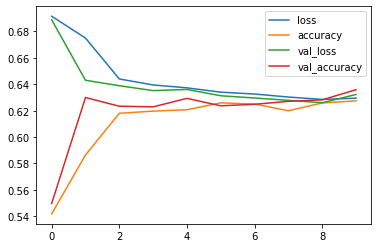

In [25]:
history_lstm1 = pd.DataFrame(history_lstm.history)

history_lstm1.plot()

In [26]:
history_lstm1

,loss,accuracy,val_loss,val_accuracy
0,0.691544,0.541770,0.688855,0.549687
1,0.675021,0.586430,0.643030,0.629957
2,0.644034,0.618015,0.638900,0.623375
3,0.639468,0.619667,0.635202,0.622893
4,0.637295,0.620699,0.636081,0.629314
5,0.634002,0.625929,0.631297,0.623696
6,0.632610,0.625034,0.629601,0.624819
7,0.630324,0.619942,0.627825,0.627067
8,0.628524,0.625860,0.626023,0.628191
9,0.629476,0.627443,0.632256,0.635897


## 4.Test the model with your own example.



In [27]:
def predict(news):
    txt = cleantext(news)
    txt = [txt]
    cv = CountVectorizer(max_features=2000)
    tr = cv.fit_transform(txt).toarray()
    test = tf.keras.preprocessing.sequence.pad_sequences(tr, padding='post')
    
    label = model.predict(test)
    return label

In [28]:
result = predict('recipe circulating social media claimed that garlic cured coronavirus')

if(result < 0.5):
    print("Fake News")
else:
    print("Not a Fake News")

1/1 [==============================] - 1s 644ms/step
Fake News


## 5.Build the model by using 

1.   Simple RNN with two layers
2.   Bidirectional LSTM



Build the model using Simple RNN (2 layers)

In [29]:
rnn_model = Sequential()
rnn_model.add(Embedding(2000, 20))
rnn_model.add(SimpleRNN(10))
# rnn_model.add(Dense(6, activation='relu'))
rnn_model.add(Dense(1, activation='sigmoid'))

In [30]:
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 20)          40000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 10)                310       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 40,321
Trainable params: 40,321
Non-trainable params: 0
_________________________________________________________________


In [31]:
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_rnn = rnn_model.fit(X_train, y_train, batch_size=500, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
30/30 [==============================] - 42s 1s/step - loss: 0.6866 - accuracy: 0.5533 - val_loss: 0.6645 - val_accuracy: 0.6730
Epoch 2/10
30/30 [==============================] - 39s 1s/step - loss: 0.6469 - accuracy: 0.6821 - val_loss: 0.6364 - val_accuracy: 0.6762
Epoch 3/10
30/30 [==============================] - 41s 1s/step - loss: 0.6233 - accuracy: 0.7102 - val_loss: 0.6129 - val_accuracy: 0.7216
Epoch 4/10
30/30 [==============================] - 40s 1s/step - loss: 0.6031 - accuracy: 0.7282 - val_loss: 0.5949 - val_accuracy: 0.7374
Epoch 5/10
30/30 [==============================] - 40s 1s/step - loss: 0.5858 - accuracy: 0.7428 - val_loss: 0.5787 - val_accuracy: 0.7430
Epoch 6/10
30/30 [==============================] - 39s 1s/step - loss: 0.5709 - accuracy: 0.7488 - val_loss: 0.5648 - val_accuracy: 0.7489
Epoch 7/10
30/30 [==============================] - 39s 1s/step - loss: 0.5581 - accuracy: 0.7535 - val_loss: 0.5533 - val_accuracy: 0.7529
Epoch 8/10
30/30 [==

In [32]:
score, acc = rnn_model.evaluate(X_test, y_test, batch_size=500)
print('Test score:', score)
print('Test accuracy:', acc)

13/13 [==============================] - 3s 233ms/step - loss: 0.5300 - accuracy: 0.7629
Test score: 0.5300129652023315
Test accuracy: 0.7628833055496216


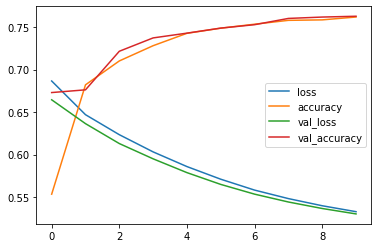

In [33]:
history_rnn1 = pd.DataFrame(history_rnn.history)

history_rnn1.plot()

Build the model using Bi-directional LSTM

In [34]:
bidirect_model = Sequential()
bidirect_model.add(Embedding(2000, 20))
bidirect_model.add(Bidirectional(LSTM(10)))
bidirect_model.add(Dense(1, activation='sigmoid'))

In [35]:
bidirect_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 20)          40000     
                                                                 
 bidirectional (Bidirectiona  (None, 20)               2480      
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 42,501
Trainable params: 42,501
Non-trainable params: 0
_________________________________________________________________


In [36]:
bidirect_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_bidirect = bidirect_model.fit(X_train, y_train, batch_size=500, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
30/30 [==============================] - 124s 4s/step - loss: 0.6912 - accuracy: 0.5414 - val_loss: 0.6895 - val_accuracy: 0.5230
Epoch 2/10
30/30 [==============================] - 112s 4s/step - loss: 0.6808 - accuracy: 0.5765 - val_loss: 0.6583 - val_accuracy: 0.6269
Epoch 3/10
30/30 [==============================] - 111s 4s/step - loss: 0.6490 - accuracy: 0.6224 - val_loss: 0.6425 - val_accuracy: 0.6227
Epoch 4/10
30/30 [==============================] - 115s 4s/step - loss: 0.6475 - accuracy: 0.6212 - val_loss: 0.6454 - val_accuracy: 0.6284
Epoch 5/10
30/30 [==============================] - 113s 4s/step - loss: 0.6434 - accuracy: 0.6257 - val_loss: 0.6415 - val_accuracy: 0.6288
Epoch 6/10
30/30 [==============================] - 117s 4s/step - loss: 0.6394 - accuracy: 0.6269 - val_loss: 0.6378 - val_accuracy: 0.6275
Epoch 7/10
30/30 [==============================] - 115s 4s/step - loss: 0.6378 - accuracy: 0.6254 - val_loss: 0.6351 - val_accuracy: 0.6277
Epoch 8/10
30

In [37]:
score, acc = bidirect_model.evaluate(X_test, y_test, batch_size=500)
print('Test score:', score)
print('Test accuracy:', acc)

13/13 [==============================] - 11s 852ms/step - loss: 0.6289 - accuracy: 0.6250
Test score: 0.6289162635803223
Test accuracy: 0.6249799132347107


In [ ]:
history_bidirect1 = pd.DataFrame(history_bidirect.history)

history_bidirect1.plot()

## 6. Compare the results of LSTM, RNN (two layers) and Bi-directional LSTM models 

In [39]:
# You would have to run these for more epochs and more data and then create a table for results.
from IPython.display import display 
print('***********************************************************************')
print('***************** Comparison of different models **********************\n\n')

all_rows = [[history_lstm1['loss'][9],
             history_rnn1['loss'][9],
             history_bidirect1['loss'][9]], 
            [history_lstm1['accuracy'][9],
            history_rnn1['accuracy'][9],
            history_bidirect1['accuracy'][9]],
           [history_lstm1['val_loss'][9],
            history_rnn1['val_loss'][9],
            history_bidirect1['val_loss'][9]], 
            [history_lstm1['val_accuracy'][9],
            history_rnn1['val_accuracy'][9],
            history_bidirect1['val_accuracy'][9]]]

df = pd.DataFrame(all_rows, columns=['LSTM', 'RNN', 'BILSTM'])
df.style.background_gradient(cmap ='viridis').set_properties(**{'font-size': '20px'})
df.index = ['Loss', 'Accuracy', 'Validation Loss', 'Validation Accuracy']
df.style.set_properties(**{'border': '1.5px solid black','color': 'blue'}) 

***********************************************************************
***************** Comparison of different models **********************




,LSTM,RNN,BILSTM
Loss,0.629476,0.532648,0.631059
Accuracy,0.627443,0.761974,0.624484
Validation Loss,0.632256,0.530013,0.628916
Validation Accuracy,0.635897,0.762883,0.624980


## 7. Intrepret your solution based on the results

Comparing all the 3 models, 

    RNN takes less computation time compared to LSTM and Bidirectional LSTM
    
    Both Accuracy and Validation Accuracy of the Simple RNN model is higher 
    
    Compared to LSTM and Bidirectional LSTM, LSTM's accuracy is higher and loss is lesser than Bidirectional LSTM
    
    Out of the all three models, Simple RNN with 2 layers outperforms the other 2 models and it is the best model